In [1]:
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Input, Flatten, LSTM, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from types import SimpleNamespace
import keras
import numpy as np
import pandas as pd
import pydicom
import cv2
from sklearn import preprocessing
import re
import matplotlib.pyplot as plt
import os 
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sqlite3
import ast

from data_generator import *
from process_data import *

tf.config.run_functions_eagerly(True)

In [2]:
wandb.login(relogin=True)



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 1
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Daniel/.netrc


True

****DATA PREPROCESSING****

In [18]:
def string_to_list(string_repr):
    return eval(string_repr) 

connection = sqlite3.connect("C:/Users/Daniel/Desktop/RSNA_Abdominal_Trauma/local_database/training_data.db")
    # ATTENTION ABOUT THE TABLE FROM THE DB YOU CONNECT!!
sql = pd.read_sql_query("SELECT * FROM base_data", connection)
data = pd.DataFrame(sql, columns =["Patient_id", "Series_id", "Patient_paths", "Patient_category"])    
data['Patient_paths'] = data['Patient_paths'].apply(string_to_list)

data_positive = data[data["Patient_category"] == 1].sample(frac=1, random_state=42)
data_positive = data_positive.reset_index(drop=True)   
data_positive = data_positive.drop_duplicates(subset=['Patient_id'], keep='first')
data_positive = data_positive.sample(n=25, random_state=50)

data_negative = data[data["Patient_category"] == 0].sample(frac=1, random_state=42)
data_negative = data_negative.reset_index(drop=True)
data_negative.drop_duplicates(subset=['Patient_id'], keep='first')
data_negative = data_negative.sample(n=25, random_state=50)

merged_data = pd.concat([data_positive, data_negative], ignore_index=True).sample(frac=1, random_state=42)
merged_data["Patient_paths"] = merged_data["Patient_paths"].astype(str)   
#merged_data.drop('Patient_paths', axis=1, inplace=True)


merged_data.to_sql(name="balanced_data", con=connection, if_exists="replace", index=False)

50

In [19]:
merged_data

,Patient_id,Series_id,Patient_paths,Patient_category
13,43342,64389,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,1
39,59749,36258,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
30,3267,58985,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
45,6239,54652,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
17,16343,52163,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,1
48,4668,52219,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
26,5900,3118,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
25,4463,12816,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
32,14989,59710,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,0
19,41450,65029,['D:/Downloads/rsna-2023-abdominal-trauma-dete...,1


In [5]:
 #Organize hyperparameters to track down
config = SimpleNamespace(
    lstm_units = 100,
    L_R = 1e-4,
    LOSS = "binary_crossentropy",
    METRICS = "accuracy",
    EPOCHS = 200,
    BATCH_SIZE = 64
    )


#train_data = pd.read_csv(f"D:/Downloads/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
#cat_data = pd.read_csv(f"D:/Downloads/rsna-2023-abdominal-trauma-detection/train.csv")
#path = f"D:/Downloads/rsna-2023-abdominal-trauma-detection/train_images/"
#number_idx = 400 # Number of patients considered for the training


In [20]:
connection = sqlite3.connect("C:/Users/Daniel/Desktop/RSNA_Abdominal_Trauma/local_database/training_data.db")
# ATTENTION ABOUT THE TABLE FROM THE DB YOU CONNECT!!
sql = pd.read_sql_query("SELECT * FROM balanced_data", connection)
data = pd.DataFrame(sql, columns =["Patient_id", "Series_id", "Patient_paths", "Patient_category"])
data['Patient_paths'] = data['Patient_paths'].apply(ast.literal_eval)

In [21]:
data

,Patient_id,Series_id,Patient_paths,Patient_category
0,43342,64389,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,1
1,59749,36258,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
2,3267,58985,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
3,6239,54652,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
4,16343,52163,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,1
5,4668,52219,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
6,5900,3118,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
7,4463,12816,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
8,14989,59710,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,0
9,41450,65029,[D:/Downloads/rsna-2023-abdominal-trauma-detec...,1


In [22]:
processed_data = process_balanced_data(data)

In [23]:
processed_data

,Paths,Labels
0,D:/Downloads/rsna-2023-abdominal-trauma-detect...,1
1,D:/Downloads/rsna-2023-abdominal-trauma-detect...,1
2,D:/Downloads/rsna-2023-abdominal-trauma-detect...,1
3,D:/Downloads/rsna-2023-abdominal-trauma-detect...,1
4,D:/Downloads/rsna-2023-abdominal-trauma-detect...,1
...,...,...
16879,D:/Downloads/rsna-2023-abdominal-trauma-detect...,0
16880,D:/Downloads/rsna-2023-abdominal-trauma-detect...,0
16881,D:/Downloads/rsna-2023-abdominal-trauma-detect...,0
16882,D:/Downloads/rsna-2023-abdominal-trauma-detect...,0


In [24]:
image_paths = processed_data["Paths"]
labels = processed_data["Labels"]

In [25]:
data_generator = SuperDataGenerator(x_set=image_paths, y_set=labels, batch_size=config.BATCH_SIZE, target_size=(128,128), window_width=400, window_level=50)

****Build Model Arquitecture****

In [12]:
def conv_block(input, num_filters):

	x = Conv2D(num_filters, 3, padding="same")(input)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	x = Conv2D(num_filters, 3, padding="same")(x)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	return x 

def encoder_block(input, num_filters):

	x = conv_block(input, num_filters)
	p = MaxPool2D((2, 2))(x)
	return x, p

def dense_block(input_shape, num_classes):

	inputs = Input(shape=input_shape)
	
	x = Flatten()(inputs)
	dense_layer_1 = Dense(units=512, activation='relu')(x)
	dense_layer_1 = Dropout(0.4)(dense_layer_1)

	#dense_layer_2 = Dense(units=256, activation='relu')(dense_layer_1)
	#dense_layer_2 = Dropout(0.4)(dense_layer_2)
	output_layer = Dense(units=num_classes, activation='softmax')(dense_layer_1)

	return output_layer

def build_unet_encoder_model_lstm(input_shape):
    units = 128
    inputs = Input(input_shape)

	#ENCODER
    s1, p1 = encoder_block(inputs, units/2)
    s2, p2 = encoder_block(p1, units)
    s3, p3 = encoder_block(p2, units*2)
    s4, p4 = encoder_block(p3, units*4)
    b1 = conv_block(p4, units*8)
    b2 = Flatten()(b1)
    encoder_output = b2 
    
    return Model(inputs, encoder_output)


def unet_encoder_lstm_model(input_shape, lstm_units):
    unet_encoder = build_unet_encoder_model_lstm(input_shape)
    # Convierte la salida del encoder en una secuencia 1D para la LSTM
    encoder_output = unet_encoder.output
    lstm_input = Reshape((-1, encoder_output.shape[1]))(encoder_output)

    # capa LSTM
    lstm_layer = LSTM(lstm_units)(lstm_input)

    # capa densa para la clasificación 
    output_layer = Dense(1, activation='sigmoid')(lstm_layer)

    model = Model(inputs=unet_encoder.input, outputs=output_layer)

    return model

****RUN OF THE MODEL****

In [13]:
if __name__ == "__main__":
    
    
    input_shape = (128, 128, 1)
    num_classes = 2
    
    #Start the wandb run
    wandb.init(project="Unet-LSTM-2D-Model_LOCAL_v2", config=config)
        
    # Hyperparameters
    #lstm_units = 100
    #L_R = 1e-5
    #OPTIMIZER=tf.keras.optimizers.SGD(learning_rate=L_R)
    #LOSS = "binary_crossentropy"
    #METRICS = ["accuracy"]
    #EPOCHS = 200
    #BATCH_SIZE = 32
    OPTIMIZER=tf.keras.optimizers.SGD(learning_rate=config.L_R)
    
    #Model training
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    model = unet_encoder_lstm_model(input_shape, config.lstm_units)
    model.compile(optimizer=OPTIMIZER, loss=config.LOSS, metrics=config.METRICS)
    model.summary()
    
    
    history = model.fit(data_generator, epochs=config.EPOCHS, #steps_per_epoch=len(processed_data) // config.BATCH_SIZE,
                        shuffle=False, callbacks=[WandbCallback(), early_stopping])

wandb: Currently logged in as: jose-lunamr. Use `wandb login --relogin` to force relogin


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                           

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/200


c:\Users\Daniel\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1052/1052 [==============================] - 818s 772ms/step - loss: 0.6432 - accuracy: 0.6356
Epoch 2/200
1052/1052 [==============================] - 826s 785ms/step - loss: 0.5503 - accuracy: 0.7373
Epoch 3/200
1052/1052 [==============================] - 806s 766ms/step - loss: 0.4376 - accuracy: 0.8239
Epoch 4/200
1052/1052 [==============================] - 812s 772ms/step - loss: 0.3363 - accuracy: 0.8862
Epoch 5/200
1052/1052 [==============================] - 818s 777ms/step - loss: 0.2584 - accuracy: 0.9247
Epoch 6/200
1052/1052 [==============================] - 809s 769ms/step - loss: 0.2000 - accuracy: 0.9507
Epoch 7/200
1052/1052 [==============================] - 809s 768ms/step - loss: 0.1567 - accuracy: 0.9662
Epoch 8/200
1052/1052 [==============================] - 819s 779ms/step - loss: 0.1246 - accuracy: 0.9766
Epoch 9/200
1052/1052 [==============================] - 812s 772ms/step - loss: 0.1006 - accuracy: 0.9839
Epoch 10/200
1052/1052 [=========================

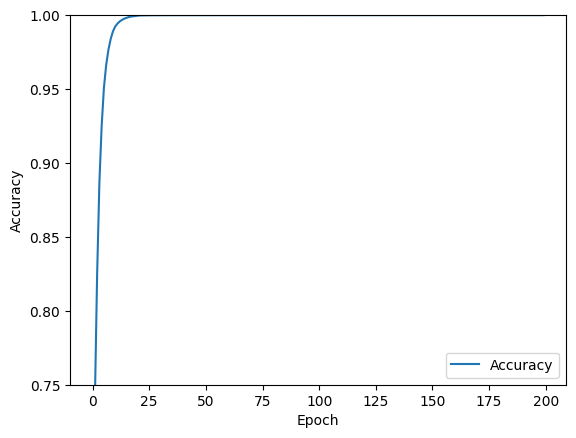

In [15]:
   
plt.plot(history.history["accuracy"], label="Accuracy")
#plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.75, 1])
plt.legend(loc="lower right")



In [16]:
save_model_path = "C:/Users/Daniel/Desktop/RSNA_Abdominal_Trauma/experiments/LSTM_Model/LSTM_model_1.h5"

model.save(save_model_path, save_format="h5")



In [17]:
#Finish the run 
wandb.finish()

accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
epoch,199
loss,0.00083


In [26]:
model.evaluate(data_generator, batch_size=64)

c:\Users\Daniel\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


264/264 [==============================] - 511s 2s/step - loss: 1.5428 - accuracy: 0.5623


[1.54278564453125, 0.5623075366020203]